#Format Data for Experiment in ABM environment

In [1]:
#Import Packages
#Needed for moving to output
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as pl
import itertools
from collections import Counter

In [2]:
from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT)

Mounted at /content/drive


In [3]:
#Install tumor-tcell
!pip install tumor-tcell
#!pip install vivarium-core==0.2.0
#!pip install vivarium-multibody

     |████████████████████████████████| 81kB 3.9MB/s 
     |████████████████████████████████| 972kB 11.1MB/s 
     |████████████████████████████████| 215kB 21.7MB/s 
  Created wheel for tumor-tcell: filename=tumor_tcell-0.0.27-cp37-none-any.whl size=44357 sha256=571c3668e502013c54fab97cd92436d3a74d5e6c7f16e6b49049fc3f63b4a216
  Stored in directory: /root/.cache/pip/wheels/5b/63/5f/de57241b2852ba216841139104f873ae7a511081d8d10341c8
  Created wheel for vivarium-core: filename=vivarium_core-0.2.11-cp37-none-any.whl size=98735 sha256=23ac677cca94ec65be33c75cae3403707ea42595fa3f4fa2bfb9c10bf197c55e
  Stored in directory: /root/.cache/pip/wheels/9d/49/8f/3f2746b1e4960f91dacf81276f4352374f9573e8ca61e267e8
  Created wheel for vivarium-multibody: filename=vivarium_multibody-0.0.6-cp37-none-any.whl size=35140 sha256=11555c3763c17248d75fb22deb53751d37a9b13cdb1d7e9af4f9a94f080f0bb1
  Stored in directory: /root/.cache/pip/wheels/f0/25/21/60b460c4ccf0ea8e38a061b526b00fb8a99aefcd444e916d1d
Successful

In [4]:
from vivarium.library.units import units, remove_units
from tumor_tcell.experiments.main import tumor_tcell_abm
from tumor_tcell.experiments.main import plots_suite
from tumor_tcell.experiments.main import get_tcells
from tumor_tcell.experiments.main import get_tumors
from tumor_tcell.library.phylogeny import get_phylogeny

In [5]:
#Read in the data from parent directory
df_2HC_exp = pd.read_csv(ROOT + '/My Drive/Research/TNT/ABM_CODEX/Scripts_Data/df_ABM_import_2HCTcell_exp_no_other.csv')
df_2HC_exp.rename(columns = {"Unnamed: 0": "cell_index"},  inplace = True) 
df_2HC_exp.set_index('cell_index', inplace = True)
df_2HC_exp

,AbsoluteY,AbsoluteX,H2Db,H2Kb,PD1,PDL1,Region,Cell Type,IFNg
cell_index,,,,,,,,,
3416,17.420858,39.383058,7439.972930,14291.879749,1765.165893,37624.272605,2HCTcell_d3,PDL1p,0
3462,17.701583,48.443346,4321.991455,5538.288774,1967.220797,15787.306125,2HCTcell_d3,PDL1p,0
3464,17.415336,11.621325,5690.707305,8733.550956,2934.491795,21794.349526,2HCTcell_d3,PDL1p,0
3474,116.736335,56.197847,4882.764345,13602.709731,3341.373360,28624.012461,2HCTcell_d3,PDL1p,0
3478,99.554303,14.165983,4688.975777,15945.410596,2197.945326,19190.868573,2HCTcell_d3,PDL1p,0
...,...,...,...,...,...,...,...,...,...
17636,28.411844,41.846260,13985.433737,41314.542279,6279.721097,37080.194910,2HCTcell_d3,PD1n,0
17640,85.217626,18.389745,11528.709624,25363.626005,13704.653409,23124.886773,2HCTcell_d3,PD1n,0
17642,162.779854,147.480997,9087.268135,34835.322826,7723.293285,29137.886824,2HCTcell_d3,PD1n,0


In [6]:
#Get bounds
min_2HC_x = 0
max_2HC_x = 200
min_2HC_y = 0
max_2HC_y = 200

ybounds = max_2HC_y - min_2HC_y
xbounds = max_2HC_x - min_2HC_x
bounds = [xbounds,ybounds]

In [7]:
#Import from Jupyter notebook
df_2HC_exp1 = df_2HC_exp.copy()

#Column Number for iloc iterating
Ypos = 0
Xpos = 1
H2Kb = 3
PD1 = 4
PDL1 = 5
Celltype = 7
IFNg_con = 8 

tumor_diameter = 15
tcell_diameter = 7.5

tumors = {}
IFNg = {}
tcells = {}

for i in range(len(df_2HC_exp1)):
  if df_2HC_exp1.iloc[i, Celltype] == 'PDL1p' or df_2HC_exp1.iloc[i, Celltype] == 'PDL1n':
    tumors.update({
        'tumor_'+ str(df_2HC_exp1.index[i]) : {
            'location': [df_2HC_exp1.iloc[i, Xpos]*units.um,df_2HC_exp1.iloc[i, Ypos]*units.um],
            'type': 'tumor',
            'cell_state': df_2HC_exp1.iloc[i, Celltype],
            'PDL1': df_2HC_exp1.iloc[i, PDL1],
            'MHCI': df_2HC_exp1.iloc[i, H2Kb],
            'diameter': tumor_diameter*units.um,
        }
    })
    
    IFNg.update({
        df_2HC_exp1.index[i] : {
            'amount': df_2HC_exp1.iloc[i, IFNg_con],
            'location': [df_2HC_exp1.iloc[i, Xpos]*units.um,df_2HC_exp1.iloc[i, Ypos]*units.um],
        }
    })

  else: 
    tcells.update({
        'tcell_'+ str(df_2HC_exp1.index[i]) : {
            'location': [df_2HC_exp1.iloc[i, Xpos]*units.um,df_2HC_exp1.iloc[i, Ypos]*units.um],
            'type': 'tcell',
            'cell_state': df_2HC_exp1.iloc[i, Celltype],
            'PD1': df_2HC_exp1.iloc[i, PD1],
            'diameter': tcell_diameter*units.um,
        }
    })
    IFNg.update({
        df_2HC_exp1.index[i]: {
        'amount': df_2HC_exp1.iloc[i, IFNg_con],
        'location': [df_2HC_exp1.iloc[i, Xpos]*units.um,df_2HC_exp1.iloc[i, Ypos]*units.um],
        }
    })

tcells

{'tcell_17573': {'PD1': 37905.35372440419,
  'cell_state': 'PD1p',
  'diameter': 7.5 micrometer,
  'location': [96.44950048828129 micrometer, 103.68050146484372 micrometer],
  'type': 'tcell'},
 'tcell_17574': {'PD1': 36077.359570303546,
  'cell_state': 'PD1p',
  'diameter': 7.5 micrometer,
  'location': [94.11488012695317 micrometer, 145.88664550781255 micrometer],
  'type': 'tcell'},
 'tcell_17575': {'PD1': 27239.05224499536,
  'cell_state': 'PD1p',
  'diameter': 7.5 micrometer,
  'location': [112.01915869140623 micrometer, 155.55481787109375 micrometer],
  'type': 'tcell'},
 'tcell_17633': {'PD1': 3377.8649764575835,
  'cell_state': 'PD1n',
  'diameter': 7.5 micrometer,
  'location': [27.06428881835939 micrometer, 54.30012841796884 micrometer],
  'type': 'tcell'},
 'tcell_17635': {'PD1': 4902.089708080086,
  'cell_state': 'PD1n',
  'diameter': 7.5 micrometer,
  'location': [35.5597666015625 micrometer, 27.292533203125004 micrometer],
  'type': 'tcell'},
 'tcell_17636': {'PD1': 6279.

#Run tumor-tcell ABM Experiment

In [8]:
#using experimental CODEX data
data = tumor_tcell_abm(tumors=tumors, tcells=tcells, total_time=50000, bounds=[b*units.um for b in bounds], halt_threshold=300,emit_step=600)
data;

Initializing experiment tumor_tcell_20210407.160041


100%|██████████| 84/84 [03:29<00:00,  2.49s/it]


Completed in 209.03 seconds


In [83]:
##With simulated data
N_TUMORS = 120
N_TCELLS = 12
PD1n_per = 0.8
PDL1n_per = 0.6
DEFAULT_TUMORS = get_tumors(number=N_TUMORS, state_per=PD1n_per)
DEFAULT_TCELLS = get_tcells(number=N_TCELLS, state_per=PDL1n_per)

data = tumor_tcell_abm(total_time=50000, tumors=DEFAULT_TUMORS, tcells=DEFAULT_TCELLS, halt_threshold=300,emit_step=60)
data;

Initializing experiment tumor_tcell_20210407.170357


100%|██████████| 84/84 [04:45<00:00,  3.40s/it]


Completed in 285.76 seconds


In [84]:
data = remove_units(data)
data;

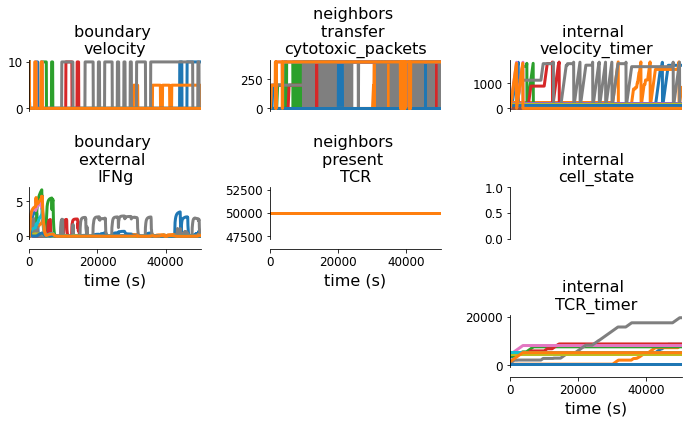

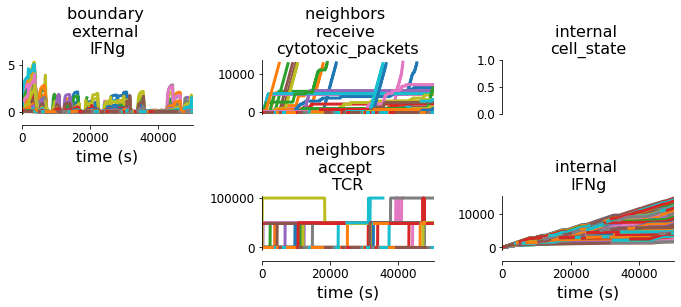

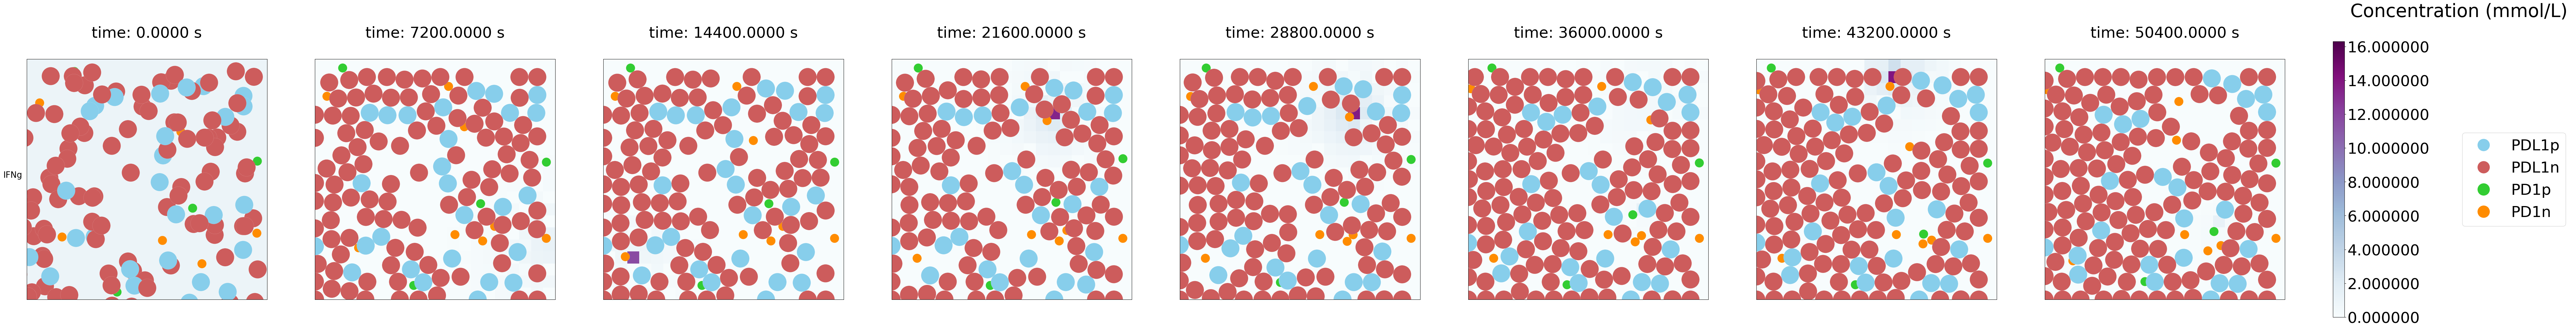

In [85]:
#Plot the data using tumor-tcell experiment notebook and save in current directory
outdir = ROOT + '/My Drive/Research/TNT/ABM_CODEX/Scripts_Data/'
fig1, fig2, fig3 = plots_suite(data, out_dir = outdir, bounds=[b*units.um for b in bounds])

#Convert ABM data output to pandas dataframe format

In [65]:
#Convert to initial dataframe
df_data = pd.DataFrame(data)


#Extract agents from the data
df_copy = df_data.copy()
df_agents = df_copy.iloc[0,:]
agents_dict = df_agents.to_dict()

#reformat the dictionary into mulitiindexed dataframe
reform_agents = {(level1_key, level2_key): values
          for level1_key, level2_dict in agents_dict.items()
          for level2_key, values in level2_dict.items()
          }
df_agents_exp1 = pd.DataFrame(reform_agents)
df_agents_multi = df_agents_exp1.T
names=['time', 'cell']
df_agents_multi.index.set_names(names, inplace=True)


#Subset only T cells from all agents
df_tcell_agents = df_agents_multi.iloc[df_agents_multi.index.get_level_values('cell').str.contains('tcell'), :]


#Subset categories and recombine in T cells
df_tcell_trans = df_tcell_agents.T
tcell_categories = []

#Extract each feature - boundary, internal, neighbors
for category in df_tcell_trans.index.values:
  df_boundary_sub = df_tcell_trans.loc[category,:]
  tcell_boundary_dict = df_boundary_sub.to_dict()
  df_boundary_sub2 = pd.DataFrame(tcell_boundary_dict)
  tcell_categories.append(df_boundary_sub2.T)

#concatenate dataframes
tcell_data = pd.concat(tcell_categories, axis=1)


#reformat T cell data for plotting
tcell_data['IFNg'] = tcell_data['external'].apply(lambda x: x.get('IFNg'))
tcell_data['transferable_cytotoxic_packets'] = tcell_data['transfer'].apply(lambda x: x.get('cytotoxic_packets'))
tcell_data['X'] = tcell_data['location'].apply(lambda x: x[0])
tcell_data['Y'] = tcell_data['location'].apply(lambda x: x[1])

#Only select columns of interest
tcell_columns = ['cell_state', 'IFNg', 'transferable_cytotoxic_packets', 'X', 'Y']
tcell_data_form = tcell_data[tcell_columns]
tcell_data_form.index.set_names(names, inplace=True)

tcell_data_form

cell_state      IFNg  ...           X           Y
time    cell                            ...                        
0.0     tcell_0         PD1p  0.000000  ...   69.862788  161.947321
        tcell_1         PD1n  0.000000  ...  147.012539   99.338011
        tcell_2         PD1p  0.000000  ...  188.276857  159.465958
        tcell_3         PD1p  0.000000  ...  129.069556  132.839160
        tcell_4         PD1p  0.000000  ...  149.111827   48.943086
...                      ...       ...  ...         ...         ...
50400.0 tcell_1AA       PD1n  0.000242  ...  163.961090   98.098314
        tcell_6A        PD1n  0.000244  ...  193.118328   86.026920
        tcell_6B        PD1n  0.000244  ...  185.732424   85.179555
        tcell_8A        PD1n  0.000229  ...   24.992299  170.241297
        tcell_8B        PD1n  0.000229  ...   17.587419  170.112968

[10346 rows x 5 columns]

In [66]:
####Extract death log statistics
df_death = df_copy.iloc[1,:]
death_dict = df_death.to_dict()

#reformat the dictionary into mulitiindexed dataframe
reform_death = {(level1_key, level2_key): values
          for level1_key, level2_dict in death_dict.items()
          for level2_key, values in level2_dict.items()}

#Make dataframe
df_death_exp1 = pd.DataFrame(reform_death)
df_death_multi = df_death_exp1.T
names=['time', 'cell']
df_death_multi.index.set_names(names, inplace=True)
df_death_multi.columns = ['time', 'death']

#subset only where death is not equal to false
df_death_sub = df_death_multi[~(df_death_multi['death'] == False)]

#Only get the final log of the death than contains all the death information
df_last_death = df_death_sub.loc[df_death_sub.index.levels[0][-1]]

#Subset only T cells from all agents
df_tcell_death = df_last_death.iloc[df_last_death.index.get_level_values('cell').str.contains('tcell'), :]
df_tumor_death = df_last_death.iloc[df_last_death.index.get_level_values('cell').str.contains('tumor'), :]



##Do for T cells
#sort deaths by time
df_tcell_death.sort_values(by=['time'], inplace=True)

#Get different death groupings and count total over time
death_types_list = list(df_tcell_death['death'].unique())
for death_type in death_types_list:
  df_tcell_death[death_type] = df_tcell_death['death'].apply(lambda x: 1 if x==death_type else 0)
  df_tcell_death['total_'+str(death_type)] = df_tcell_death[death_type].cumsum()

#get total death count over time
total_col_t = [col for col in df_tcell_death.columns if 'total' in col]
df_tcell_death['total_death'] = df_tcell_death[total_col_t].sum(axis = 1)


##Do for Tumors
#sort deaths by time
df_tumor_death.sort_values(by=['time'], inplace=True)

#Get different death groupings and count total over time
death_types_list = list(df_tumor_death['death'].unique())
for death_type in death_types_list:
  df_tumor_death[death_type] = df_tumor_death['death'].apply(lambda x: 1 if x==death_type else 0)
  df_tumor_death['total_'+str(death_type)] = df_tumor_death[death_type].cumsum()

#get total death count over time
total_col = [col for col in df_tumor_death.columns if 'total' in col]
df_tumor_death['total_death'] = df_tumor_death[total_col].sum(axis = 1)

df_tumor_death;

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

In [67]:
#Subset only Tumor cells from all agents
df_tumor_agents = df_agents_multi.iloc[df_agents_multi.index.get_level_values('cell').str.contains('tumor'), :]


#Subset categories and recombine in Tumor cells
df_tumor_trans = df_tumor_agents.T
tumor_categories = []

#Extract each feature - boundary, internal, neighbors
for category in df_tumor_trans.index.values:
  df_boundary_sub = df_tumor_trans.loc[category,:]
  tumor_boundary_dict = df_boundary_sub.to_dict()
  df_boundary_sub2 = pd.DataFrame(tumor_boundary_dict)
  tumor_categories.append(df_boundary_sub2.T)

#concatenate dataframes
tumor_data = pd.concat(tumor_categories, axis=1)
tumor_data;

#reformat Tumor cell data for plotting
tumor_data['IFNg'] = tumor_data['external'].apply(lambda x: x.get('IFNg'))
tumor_data['cytotoxic_packets'] = tumor_data['receive'].apply(lambda x: x.get('cytotoxic_packets'))
tumor_data['X'] = tumor_data['location'].apply(lambda x: x[0])
tumor_data['Y'] = tumor_data['location'].apply(lambda x: x[1])
tumor_data.columns

#Only select columns of interest
tumor_columns = ['cell_state', 'IFNg', 'cytotoxic_packets', 'X', 'Y']
tumor_data_form = tumor_data[tumor_columns]
tumor_data_form.index.set_names(names, inplace=True)

tumor_data_form

cell_state      IFNg  ...           X           Y
time    cell                              ...                        
0.0     tumor_0          PDL1n  0.000000  ...   72.156788   81.608275
        tumor_1          PDL1n  0.000000  ...  105.027949   52.225999
        tumor_2          PDL1n  0.000000  ...  165.897744  188.971072
        tumor_3          PDL1n  0.000000  ...   69.316959   30.142188
        tumor_4          PDL1n  0.000000  ...   68.608603   39.222725
...                        ...       ...  ...         ...         ...
50400.0 tumor_11BBB      PDL1n  0.000232  ...   42.856870   79.847302
        tumor_44AAA      PDL1n  0.000241  ...  151.809442   75.284040
        tumor_44AAB      PDL1n  0.000239  ...  137.052802   77.356465
        tumor_37A        PDL1n  0.000233  ...  119.364212  192.500000
        tumor_37B        PDL1n  0.000233  ...  119.364212  192.500000

[138572 rows x 5 columns]

In [68]:
#phylogeny plot?

#Plotting the Data from the Experiment

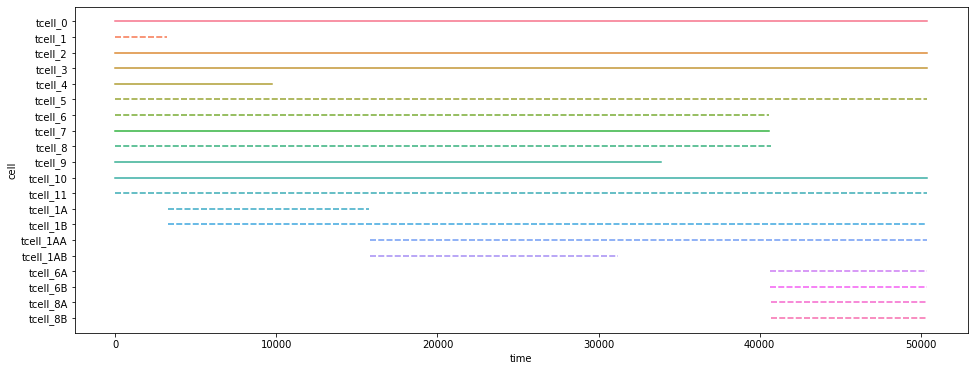

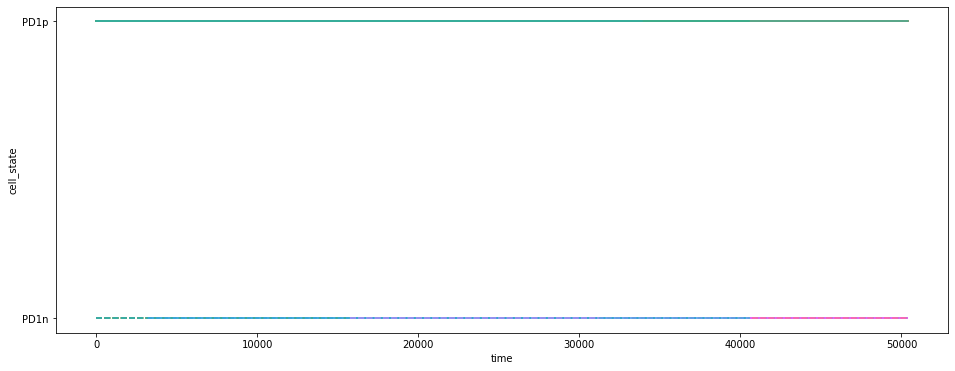

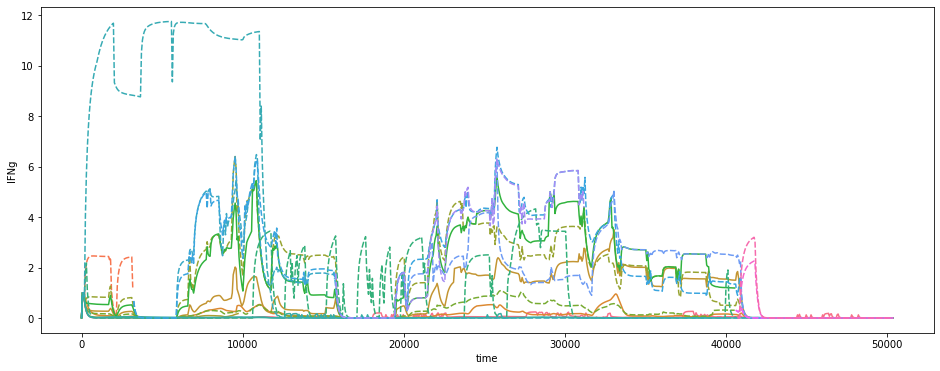

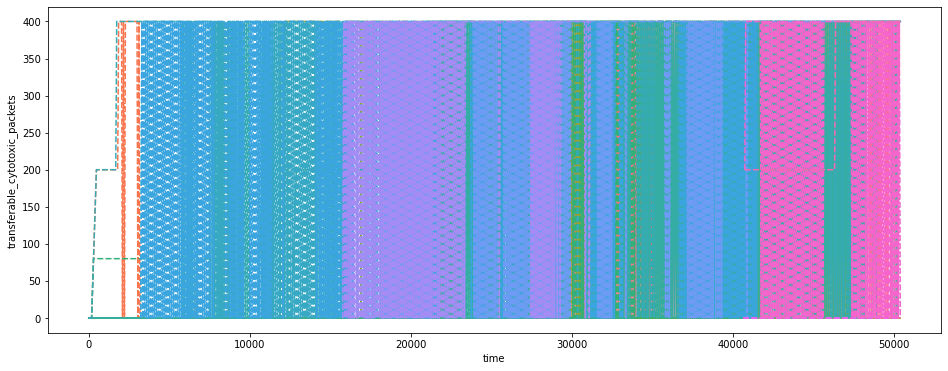

In [69]:
#reset index for plotting
tcell_plot = tcell_data_form.reset_index()
# plot the data to analyze
plotting_columns = ['cell','cell_state', 'IFNg', 'transferable_cytotoxic_packets']
for column in plotting_columns:
  pl.figure(figsize=(16, 6))
  column = sns.lineplot(data=tcell_plot, x="time", y=column, style = 'cell_state', hue="cell", legend = None)

In [70]:
#How to extract individual T cells
df_divide_T = tcell_plot.drop_duplicates('cell', keep='first')

#Get unique agent IDs
unique_T_cell = list(df_divide_T.cell.unique())

#run phylogeny function
phylogeny_T = get_phylogeny(unique_T_cell)

# get initial ancestors, daughters, and mothers
daughters_T = list(phylogeny_T.values())
daughters_T = set([item for sublist in daughters_T for item in sublist])
descendents_T = list(daughters_T)
mothers_T = set(list(phylogeny_T.keys()))
ancestors_T = list(mothers_T - daughters_T)
ancestors_T;

Text(0.5, 1.0, '# of divisions')

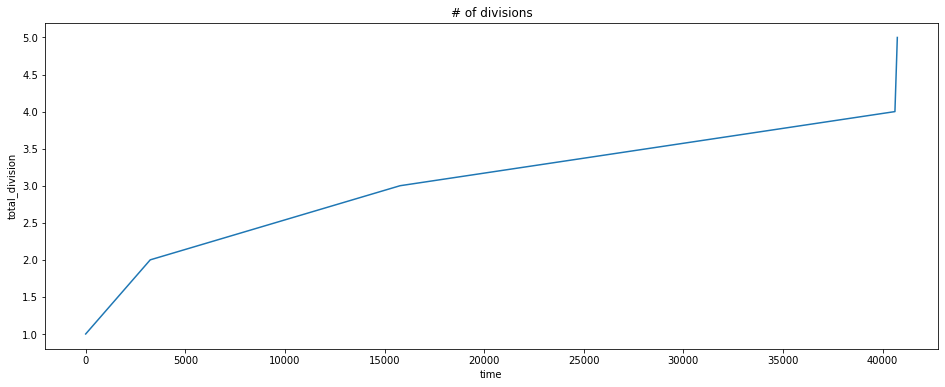

In [71]:
#Time for plotting cell divisions
div_list_T = []
for cell in descendents_T:
  div = df_divide_T[df_divide_T["cell"] == cell]['time'].min()
  div_list_T.append(div)

#get unique counts from the list
div_counts_T = Counter(div_list_T)
divide_time_T = pd.DataFrame.from_dict(div_counts_T, orient='index').reset_index()

#convert to dataframe
column_names = ['time', 'counts']
divide_time_T.columns = column_names

#divide counts by 2 because each daughter and original cell is counted twice
divide_time_T['counts'] = divide_time_T['counts'] / 2

#add 0, 0 initial point
divide_time_T.loc[-1] = [0, 0]
divide_time_T.index = divide_time_T.index + 1  # shifting index
divide_time_T = divide_time_T.sort_values(by = 'time') 

#accumulate the counts as progresses
divide_time_T['total_division'] = divide_time_T.counts.cumsum()

pl.figure(figsize=(16, 6))
div_cell_T = sns.lineplot(data=divide_time_T, x="time", y='total_division')

pl.title("# of divisions")

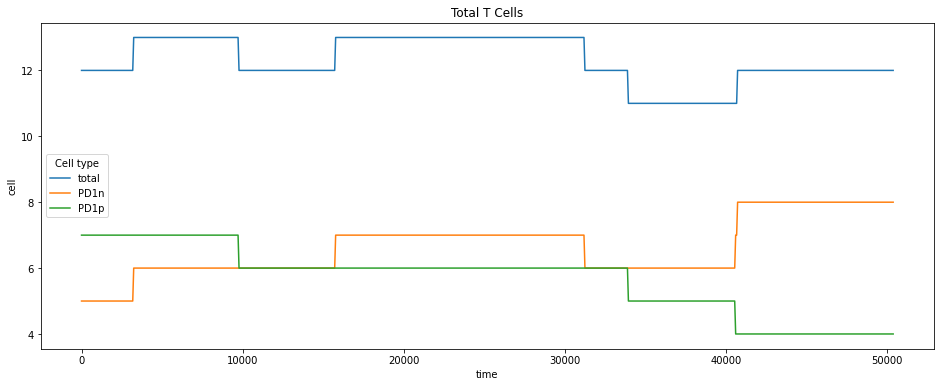

In [72]:
#Plot total cells and see how changing over time
total_tcell = tcell_plot.groupby('time')['cell'].nunique().reset_index()
tcell_state = tcell_plot.groupby(['time','cell_state'])['cell'].nunique().reset_index()
total_PD1n = tcell_state.loc[tcell_state['cell_state']=='PD1n']
total_PD1p = tcell_state.loc[tcell_state['cell_state']=='PD1p']

pl.figure(figsize=(16, 6))
ttl_tcell = sns.lineplot(data=total_tcell, x="time", y='cell', label = 'total')
ttl_PD1n = sns.lineplot(data=total_PD1n, x="time", y='cell', label = 'PD1n')
ttl_PD1p = sns.lineplot(data=total_PD1p, x="time", y='cell', label = 'PD1p')

pl.title("Total T Cells")
pl.legend(title="Cell type")

Text(0.5, 1.0, '# of deaths')

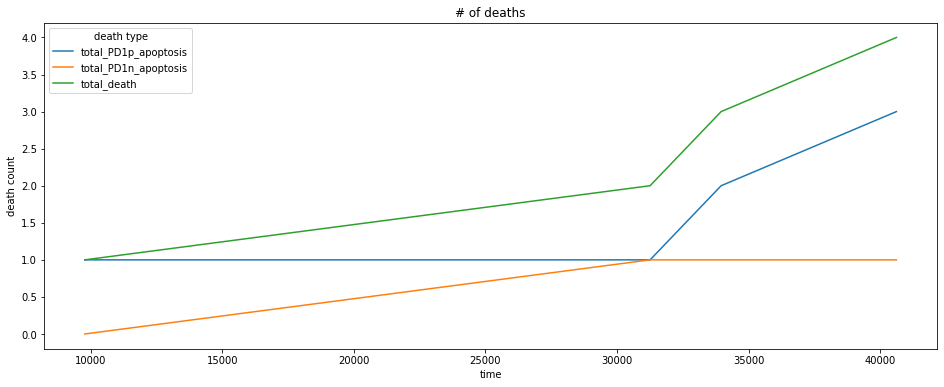

In [73]:
#Plot total number of deaths and type
total_col_t = [col for col in df_tcell_death.columns if 'total' in col]
pl.figure(figsize=(16, 6))
death_plot_t = pd.melt(df_tcell_death, id_vars= ['death', 'time'], value_vars= total_col_t)
death_plot_t.rename(columns={'variable':'death type', 'value' : 'death count'}, inplace=True)
death_cell_T = sns.lineplot(data=death_plot_t, x="time", y='death count', hue='death type')
pl.title("# of deaths")

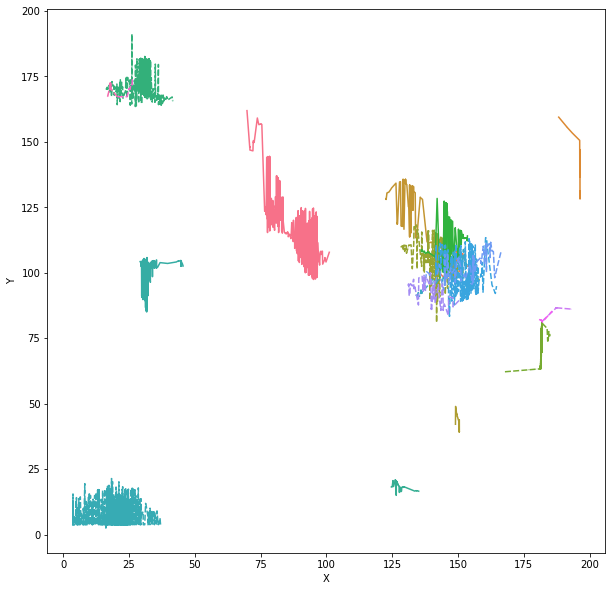

In [74]:
#Spatial
pl.figure(figsize=(10, 10))
XandY = sns.lineplot(data=tcell_plot, x="X", y="Y", style = 'cell_state', hue="cell", legend = None)

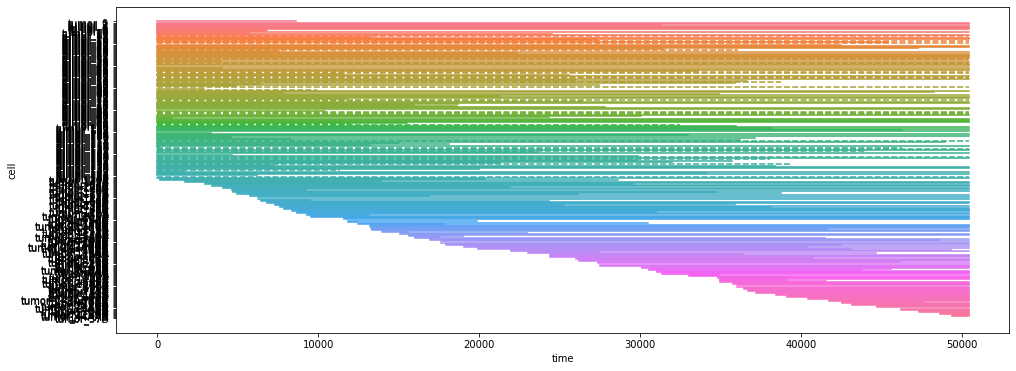

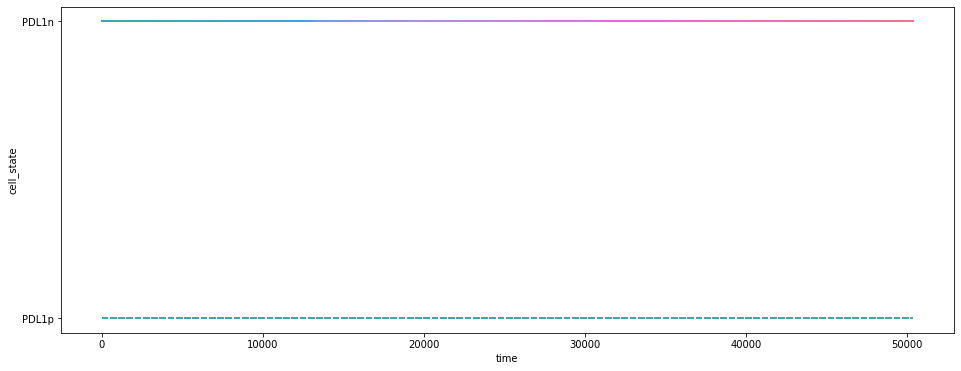

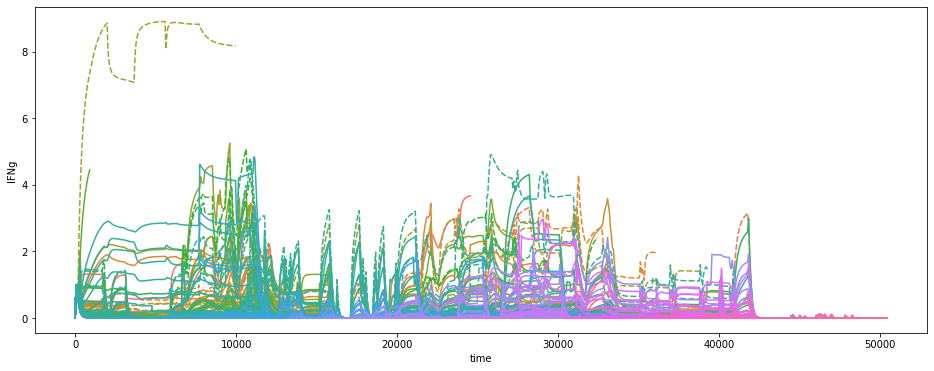

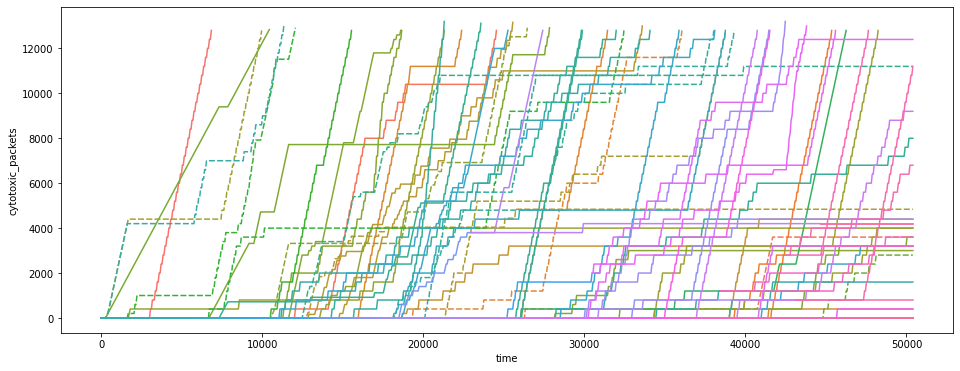

In [75]:
#reset index for plotting
tumor_plot = tumor_data_form.reset_index()

# plot the data to analyze
plotting_columns = ['cell', 'cell_state', 'IFNg', 'cytotoxic_packets']
for column in plotting_columns:
  pl.figure(figsize=(16, 6))
  column = sns.lineplot(data=tumor_plot, x="time", y=column, style = 'cell_state', hue="cell", legend = None)

In [76]:
#How to extract individual tumor cells
df_divide_tumor = tumor_plot.drop_duplicates('cell', keep='first')

#Get unique agent IDs
unique_tumor_cell = list(df_divide_tumor.cell.unique())

#run phylogeny function
phylogeny_tumor = get_phylogeny(unique_tumor_cell)

# get initial ancestors, daughters, and mothers
daughters_tumor = list(phylogeny_tumor.values())
daughters_tumor = set([item for sublist in daughters_tumor for item in sublist])
descendents_tumor = list(daughters_tumor)
mothers_tumor = set(list(phylogeny_tumor.keys()))
ancestors_tumor = list(mothers_tumor - daughters_tumor)
descendents_tumor;

Text(0.5, 1.0, '# of divisions')

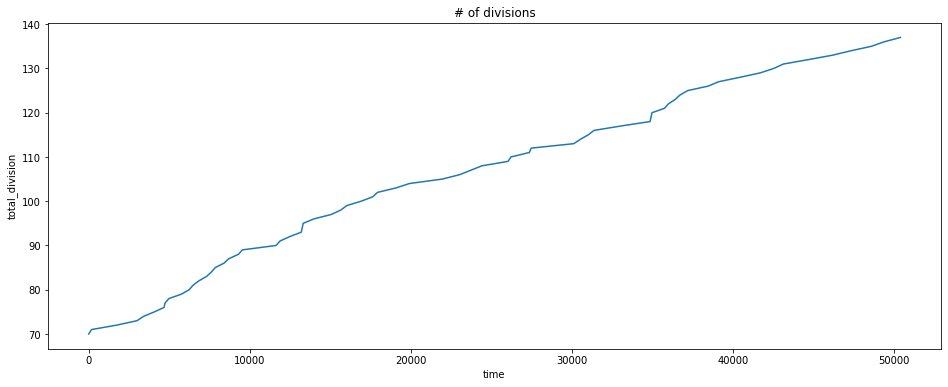

In [77]:
#Time for plotting cell divisions
div_list_tumor = []
for cell in descendents_tumor:
  div = df_divide_tumor[df_divide_tumor["cell"] == cell]['time'].min()
  div_list_tumor.append(div)

#get unique counts from the list
div_counts_tumor = Counter(div_list_tumor)
divide_time_tumor = pd.DataFrame.from_dict(div_counts_tumor, orient='index').reset_index()

#convert to dataframe
column_names = ['time', 'counts']
divide_time_tumor.columns = column_names

#divide counts by 2 because each daughter and original cell is counted twice
divide_time_tumor['counts'] = divide_time_tumor['counts'] / 2

#add 0, 0 initial point
divide_time_tumor.loc[-1] = [0, 0]
divide_time_tumor.index = divide_time_tumor.index + 1  # shifting index
divide_time_tumor = divide_time_tumor.sort_values(by = 'time') 

#accumulate the counts as progresses
divide_time_tumor['total_division'] = divide_time_tumor.counts.cumsum()

pl.figure(figsize=(16, 6))
div_cell_tumor = sns.lineplot(data=divide_time_tumor, x="time", y='total_division')

pl.title("# of divisions")

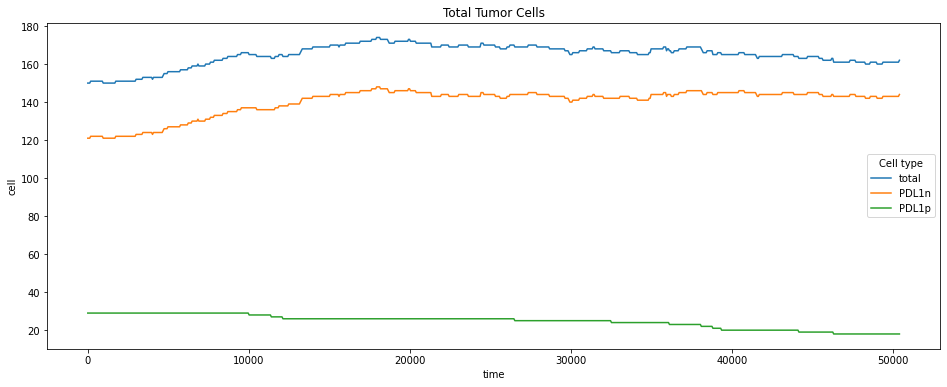

In [78]:
#Plot total cells and see how changing over time
total_tumor = tumor_plot.groupby('time')['cell'].nunique().reset_index()
tumor_state = tumor_plot.groupby(['time','cell_state'])['cell'].nunique().reset_index()
total_PDL1n = tumor_state.loc[tumor_state['cell_state']=='PDL1n']
total_PDL1p = tumor_state.loc[tumor_state['cell_state']=='PDL1p']

pl.figure(figsize=(16, 6))
ttl_tumorcell = sns.lineplot(data=total_tumor, x="time", y='cell', label = 'total')
ttl_PDL1n = sns.lineplot(data=total_PDL1n, x="time", y='cell', label = 'PDL1n')
ttl_PDL1p = sns.lineplot(data=total_PDL1p, x="time", y='cell', label = 'PDL1p')

pl.title("Total Tumor Cells")
pl.legend(title="Cell type")

Text(0.5, 1.0, '# of deaths')

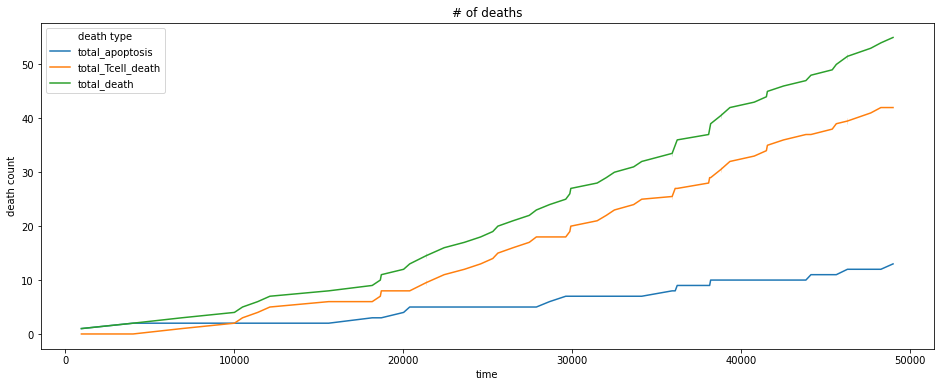

In [79]:
#Plot total number of deaths and type
total_col = [col for col in df_tumor_death.columns if 'total' in col]
pl.figure(figsize=(16, 6))
death_plot = pd.melt(df_tumor_death, id_vars= ['death', 'time'], value_vars= total_col)
death_plot.rename(columns={'variable':'death type', 'value' : 'death count'}, inplace=True)
death_cell = sns.lineplot(data=death_plot, x="time", y='death count', hue='death type')
pl.title("# of deaths")

#Spatial Widget

In [80]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline

def plot_func(time):
    x = tcell_plot[tcell_plot['time']<=time]['X']
    y = tcell_plot[tcell_plot['time']<=time]['Y']
    data_t = tcell_plot[tcell_plot['time']<=time]
    xandy = sns.lineplot(data=data_t, x=x, y=y, hue = 'cell_state', style = 'cell', legend = None)
    pl.show()

interact(plot_func, time = widgets.FloatSlider(value=0,
                                               min=0,
                                               max=10000,
                                               step=60))

interactive(children=(FloatSlider(value=0.0, description='time', max=10000.0, step=60.0), Output()), _dom_clas…

<function __main__.plot_func>

In [81]:
tcell_plot.X.min()

3.655978683996901

In [82]:
tcell_plot.Y.min()

2.4621912054747064

In [ ]:
#tcell_plot.to_csv(ROOT + '/My Drive/Research/TNT/ABM_CODEX/Scripts_Data/'+'tcell_neg_data.csv')